# Hedge Fund X
This notebook solve the Hedge Fund X's competition challenge: Financial Modeling challenge.
This one is used to evaluate model, tuning param to find most sutable model.
To discover data set, check the other Notebook.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import datetime

In [4]:
df = pd.read_csv("../input/hedge_fund_x/train.csv")
df_test = pd.read_csv("../input/hedge_fund_x/test.csv")
df.head(5)

,data_id,period,c1,c2,c3,c4,c5,c6,c7,c8,...,c80,c81,c82,c83,c84,c85,c86,c87,c88,target
0,2,train1,0.655570,-0.000022,-0.000539,-0.001075,0.0,0.0,0.213390,0.0,...,-0.023358,-0.017041,0.0,0.060697,0.0,0.0,0.000000,-0.000202,-0.140220,1
1,3,train1,1.646430,-0.000292,-0.008367,0.009497,0.0,0.0,0.000000,0.0,...,-0.059429,-0.009109,0.0,0.021645,0.0,0.0,0.000000,-0.004382,0.455767,0
2,5,train1,-0.743010,0.004642,-0.000647,-0.003290,0.0,0.0,0.000000,0.0,...,0.001796,-0.000104,0.0,-0.024718,0.0,0.0,0.219566,0.072711,1.155580,0
3,7,train1,0.029770,-0.006343,-0.000635,-0.002516,0.0,0.0,0.160313,0.0,...,-0.005501,0.045308,0.0,-0.148852,0.0,0.0,0.000000,-0.101181,-0.954553,0
4,10,train1,-0.660243,0.012591,-0.002098,-0.022264,0.0,0.0,0.000000,0.0,...,0.029034,-0.005847,0.0,-0.007073,0.0,0.0,0.000000,-0.004842,0.436002,0


In [5]:
# We drop column period to make it same as test dataset
train1_df = df[df.period == 'train1'].drop(['period'], axis=1)

## Training
### Model definition
Define multiple models to test
_NOTE:_ Work in progress
_TODO:_ review all pipeline

In [27]:
clf_svc = SVC(C=0.1, gamma=0.1, kernel='rbf', probability=True)
clf_lr = LogisticRegression(C=0.1)
clf_knn = KNeighborsClassifier(n_neighbors=15)
clf_dt = DecisionTreeClassifier(max_depth=4)
clf_rf = RandomForestClassifier(n_estimators=80, max_depth=5)
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', clf_svc)])
pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', clf_lr)])
pipe_knn = Pipeline([('scl', StandardScaler()), ('clf', clf_knn)])

clf_ada = AdaBoostClassifier(n_estimators=100)
clf_voter = VotingClassifier(
    estimators=[('svc', pipe_svc), ('lr', pipe_lr), 
                ('knn', pipe_knn),
                ('dt', clf_dt), ('rf', clf_rf)],
    voting='soft')
clf_xgb = XGBClassifier(max_depth=7, n_estimators=150, reg_lambda=10)

train_df = train1_df[:40000] # Train 3000 data on train1 period
selected_cols = [col for col in train_df.columns if col not in ['target']]
X_train = train_df[selected_cols].values
y_train = train_df['target'].values

### Parameter tuning

In [10]:
def grid_search(clf_name, X_train, y_train, est, param_grid):
    gs = GridSearchCV(
        estimator=est, param_grid=param_grid, scoring='accuracy', cv=10)
    gs = gs.fit(X_train, y_train)
    print(clf_name, gs.best_score_)
    print(gs.best_params_)


def grid_search_svc(X_train, y_train, est):
    param_range = [0.1, 1.0, 10.0]
    param_grid = [{
        'clf__C': param_range,
        'clf__kernel': ['linear']
    }, {
        'clf__C': param_range,
        'clf__gamma': param_range,
        'clf__kernel': ['rbf']
    }]
    grid_search('svc', X_train, y_train, est, param_grid)


def grid_search_lr(X_train, y_train, est):
    param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'clf__C': param_range}]
    grid_search('lr', X_train, y_train, est, param_grid)


def grid_search_knn(X_train, y_train, est):
    param_range = [1, 5, 10, 15, 20, 25, 30, 50]
    param_grid = [{'clf__n_neighbors': param_range}]
    grid_search('knn', X_train, y_train, est, param_grid)


def grid_search_dt(X_train, y_train, est):
    param_range = [1, 2, 3, 4, 5, 6, 7, 8]
    param_grid = [{'max_depth': param_range}]
    grid_search('dt', X_train, y_train, est, param_grid)


def grid_search_rf(X_train, y_train, est):
    param_range = [80, 100, 120, 140]
    param_grid = [{'n_estimators': param_range, 'max_depth': [3, 5, 7]}]
    grid_search('rf', X_train, y_train, est, param_grid)


def grid_search_ada(X_train, y_train, est):
    param_grid = {'n_estimators': [50, 100, 200]}
    grid_search('ada', X_train, y_train, est, param_grid)


def grid_search_xgb(X_train, y_train, est):
    param_grid = [{
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 7, 9],
        'reg_lambda': [1, 10, 100]
    }]
    grid_search('xgb', X_train, y_train, est, param_grid)


# grid_search_svc(X_train, y_train, pipe_svc)
# grid_search_lr(X_train, y_train, pipe_lr)
# grid_search_knn(X_train, y_train, pipe_knn)
# grid_search_dt(X_train, y_train, clf_dt)
# grid_search_rf(X_train, y_train, clf_rf)
# grid_search_ada(X_train, y_train, clf_ada)
grid_search_xgb(X_train, y_train, clf_xgb)

('xgb', 0.69633333333333336)
{'n_estimators': 150, 'reg_lambda': 10, 'max_depth': 7}


### Evaluate all models
compare performance of all models

In [16]:
from sklearn.model_selection import cross_val_score

all_clf = [pipe_svc, pipe_lr, pipe_knn, clf_dt, clf_rf, clf_ada, clf_voter, clf_xgb]
clf_labels = ['svc', 'lr', 'knn', 'dt', 'rf','ada', 'voter', 'xgboost']

def evaluate_model(clf, clf_label, X_train, y_train, scoring_metric='accuracy'):
    scores = cross_val_score(
        estimator=clf, X=X_train, y=y_train, cv=10, scoring=scoring_metric)
    print("{3}: {0:.2f} (+/- {1:.2f}) [{2}]".format(scores.mean(), scores.std(),clf_label,scoring_metric))

def evaluate_all_model():
    print('10-fold cross validation:')
    for clf, label in zip(all_clf, clf_labels):
        evaluate_model(clf, label, X_train, y_train, 'neg_log_loss')

# evaluate_all_model()
evaluate_model(clf_xgb, 'xgboost', X_train, y_train, 'neg_log_loss')
clf_xgb.predict_proba()

neg_log_loss: -0.59 (+/- 0.02) [xgboost]


### Plot learning curves
Train model multiple times on different training set size to inspect overfit or underfit

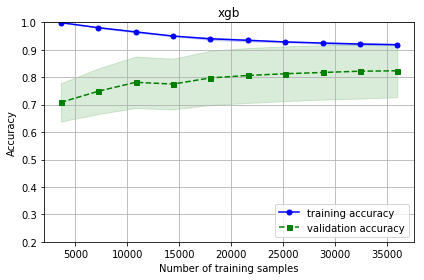

In [28]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(X_train, y_train, est, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator=est,
                       X=X_train,
                       y=y_train,
                       train_sizes=np.linspace(0.1, 1.0, 10),
                       cv=10,
                       n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.title(title)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.2, 1.0])
    plt.tight_layout()
    # plt.savefig('./figures/learning_curve.png', dpi=300)
    plt.show()

# plot_learning_curve(X_train, y_train, pipe_svc, 'svc')
# plot_learning_curve(X_train, y_train, pipe_lr, 'lr')
# plot_learning_curve(X_train, y_train, pipe_knn, 'knn')
# plot_learning_curve(X_train, y_train, clf_dt, 'dt')
# plot_learning_curve(X_train, y_train, clf_rf, 'rf')
# plot_learning_curve(X_train, y_train, clf_ada, 'ada')
# plot_learning_curve(X_train, y_train, clf_voter, 'voter')
plot_learning_curve(X_train, y_train, clf_xgb, 'xgb')

## Prediction
Prepare train & test data for predition model

In [24]:
# Train all data, to train a subset
selected_cols = [col for col in df.columns if col not in ['period', 'target']]
X_train = df[selected_cols].values
y_train = df['target'].values
X_test = df_test.values
print 'Train data shape: {}'.format(X_train.shape)
print 'Train data shape: {}'.format(X_test.shape)

Train data shape: (560000, 89)
Train data shape: (361500, 89)


Fit all training data (above code is model with cross validation) and make prediction

In [25]:
chosen_est = clf_xgb
chosen_est.fit(X_train, y_train)
predictions = chosen_est.predict_proba(X_test)[:,1]
submission = pd.DataFrame({'data_id': df_test['data_id'],'target': predictions})
submission.to_csv("submit_{:%Y%m%d-%H%M}.csv".format(datetime.datetime.now()), index=False)